In [ ]:
%matplotlib inline

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

!unzip data.zip

--2021-07-22 14:35:14--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.216.2, 99.84.216.80, 99.84.216.43, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.216.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.02s   

2021-07-22 14:35:14 (182 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.t

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je ne suis pas decourage .', 'i m not discouraged .']


Select a random pair of senetences from the data we prepared

In [ ]:
sample = random.choice(pairs)
sample

['vous etes plus intelligent que moi .', 'you re smarter than me .']

In [ ]:
input_size = input_lang.n_words
hidden_size = 256

In [ ]:
for word in input_sentence.split(' '):
  print(word)

vous
etes
plus
intelligent
que
moi
.


In order to work with embedding layer and the LSTM the inputs should be in the form of tensor, So we need to convert the sentences(words) to tensors.<br>
First we'll split the sentences by whitespaces and convert each words into indices(using word2index[word])


In [ ]:
input_sentence = sample[0]
target_sentence = sample[1]

input_indices = [input_lang.word2index[word] for word in input_sentence.split(' ')]
target_indices = [output_lang.word2index[word] for word in target_sentence.split(' ')]

input_indices, target_indices

([118, 214, 152, 135, 902, 42, 5], [129, 78, 1319, 1166, 343, 4])

We need to attach \<EOS> token to list 

In [ ]:
input_indices.append(EOS_token)
target_indices.append(EOS_token)

input_indices, target_indices

([118, 214, 152, 135, 902, 42, 5, 1], [129, 78, 1319, 1166, 343, 4, 1])

Then convert the input_indices into tensors


In [ ]:
input_tensor = torch.tensor(input_indices, dtype=torch.long, device= device)
output_tensor = torch.tensor(target_indices, dtype=torch.long, device= device)

Next, We will define a Embedding layer as well as LSTM layers for encoder


In [ ]:
embedding = nn.Embedding(input_size, hidden_size).to(device)
lstm = nn.LSTM(hidden_size, hidden_size).to(device)

In [ ]:
embedded_input = embedding(input_tensor[0]) #first word only
embedded_input.shape

torch.Size([256])

We are working with 1 sample, but we would be working for a batch. Let's fix that by converting our input_tensor into a fake batch

In [ ]:
print(embedded_input.shape)
embedded_input = embedding(input_tensor[0].view(-1, 1))
print(embedded_input.shape)

torch.Size([256])
torch.Size([1, 1, 256])


Let's build our LSTM, initialize the hidden state and cell state with Zeros(Empty state)

In [ ]:
(hidden,ct) = torch.zeros(1, 1, 256, device=device),torch.zeros(1, 1, 256, device=device)

embedded_input = embedding(input_tensor[0].view(-1, 1))
output, (hidden,ct) = lstm(embedded_input, (hidden,ct))

In [ ]:
embedded_input.shape,hidden.shape,ct.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [ ]:
output.shape, output[0, 0].shape

(torch.Size([1, 1, 256]), torch.Size([256]))

In [ ]:
encoder_outputs = torch.zeros(MAX_LENGTH, 256, device=device)
encoder_outputs.shape

torch.Size([10, 256])

In [ ]:
input_tensor.size(), input_tensor.size()[0]

(torch.Size([8]), 8)

Now we will define a empty tensor with size MAX_LENGTH to store the Encoder outputs.<br>
Then we can get the encoder outputs for each of the word in the Sentence

In [ ]:
encoder_outputs = torch.zeros(MAX_LENGTH, 256, device=device)

(encoder_hidden,encoder_ct) = torch.zeros(1, 1, 256, device=device),torch.zeros(1, 1, 256, device=device)

for i in range(input_tensor.size()[0]):  
  embedded_input = embedding(input_tensor[i].view(-1, 1))
  output, (encoder_hidden,encoder_ct) = lstm(embedded_input, (encoder_hidden,encoder_ct))
  encoder_outputs[i] += output[0,0]

Input Sentence: vous etes plus intelligent que moi .
Target Sentence: you re smarter than me .
Input indices: [118, 214, 152, 135, 902, 42, 5]
Target indices: [118, 214, 152, 135, 902, 42, 5]
After adding the <EOS> token
Input indices: [118, 214, 152, 135, 902, 42, 5, 1]
Target indices: [118, 214, 152, 135, 902, 42, 5, 1]
Input tensor: tensor([118, 214, 152, 135, 902,  42,   5,   1], device='cuda:0')
Target tensor: tensor([ 129,   78, 1319, 1166,  343,    4,    1], device='cuda:0')



Step 0
Word => vous

Input Tensor => tensor(118, device='cuda:0')


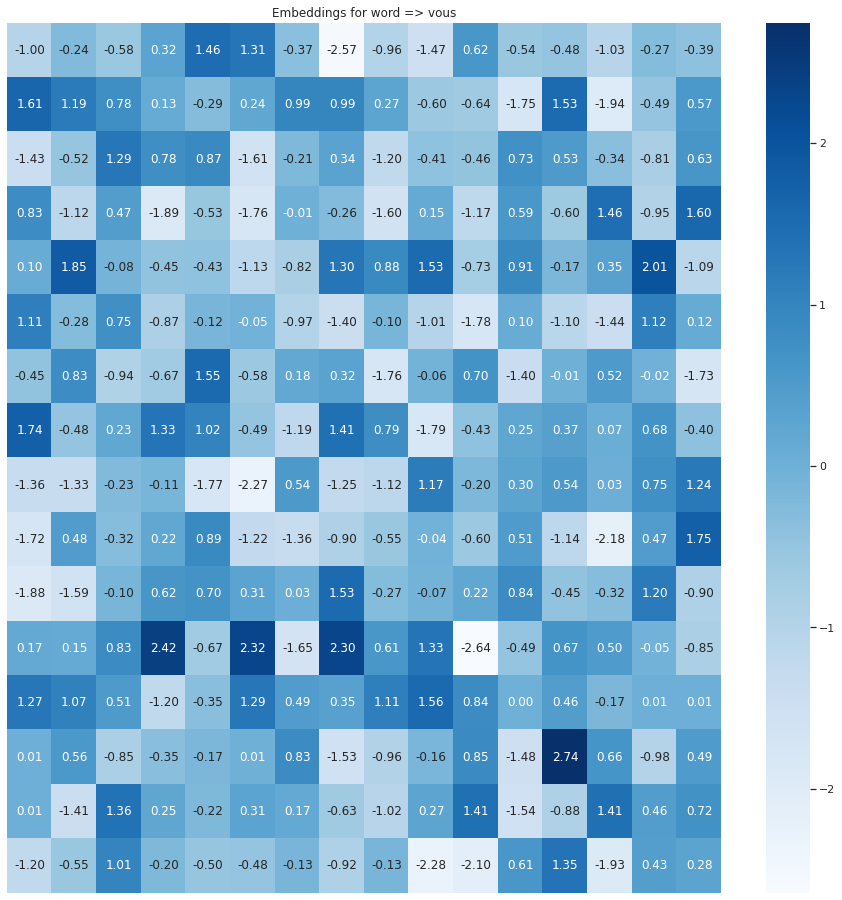

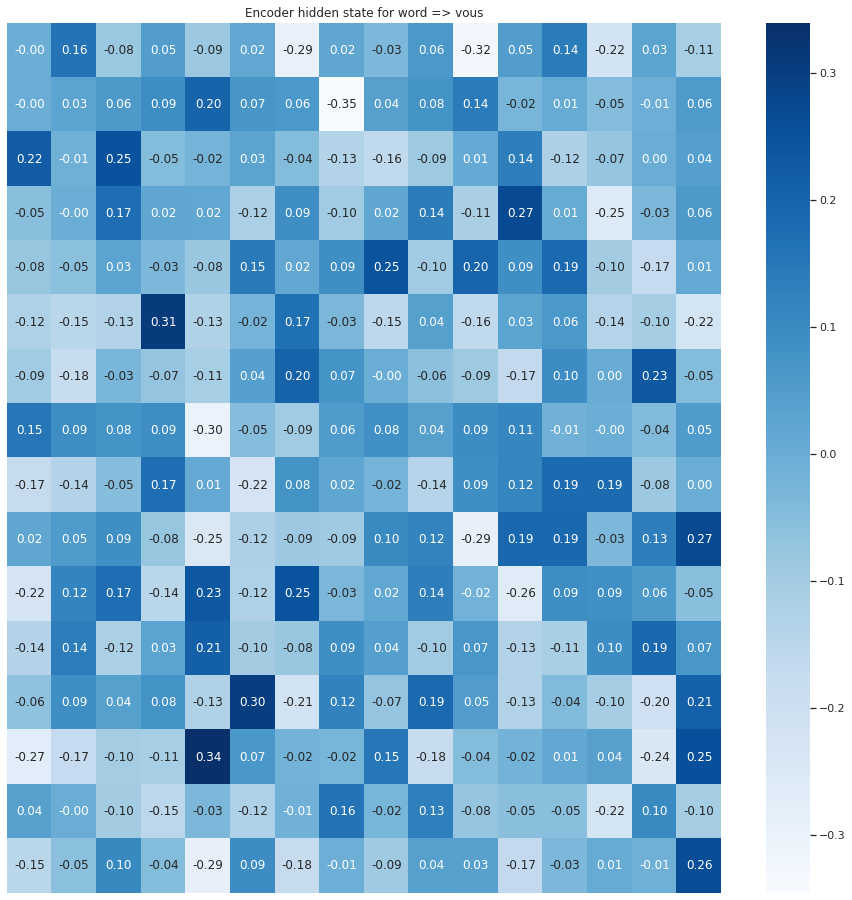




Step 1
Word => etes

Input Tensor => tensor(214, device='cuda:0')


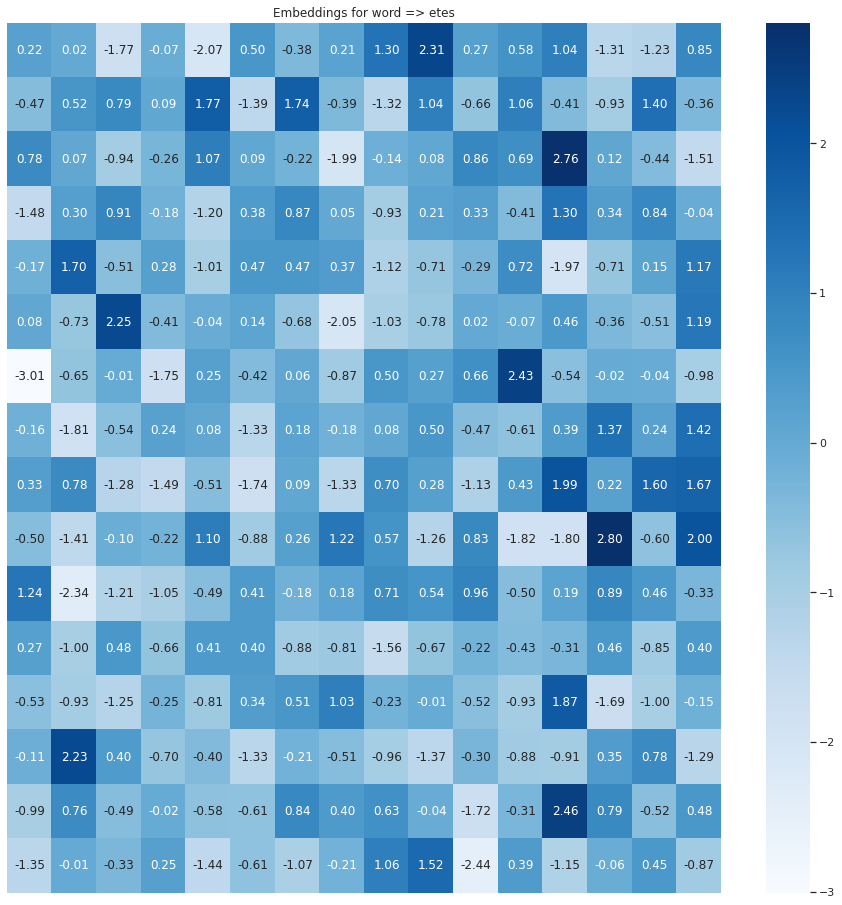

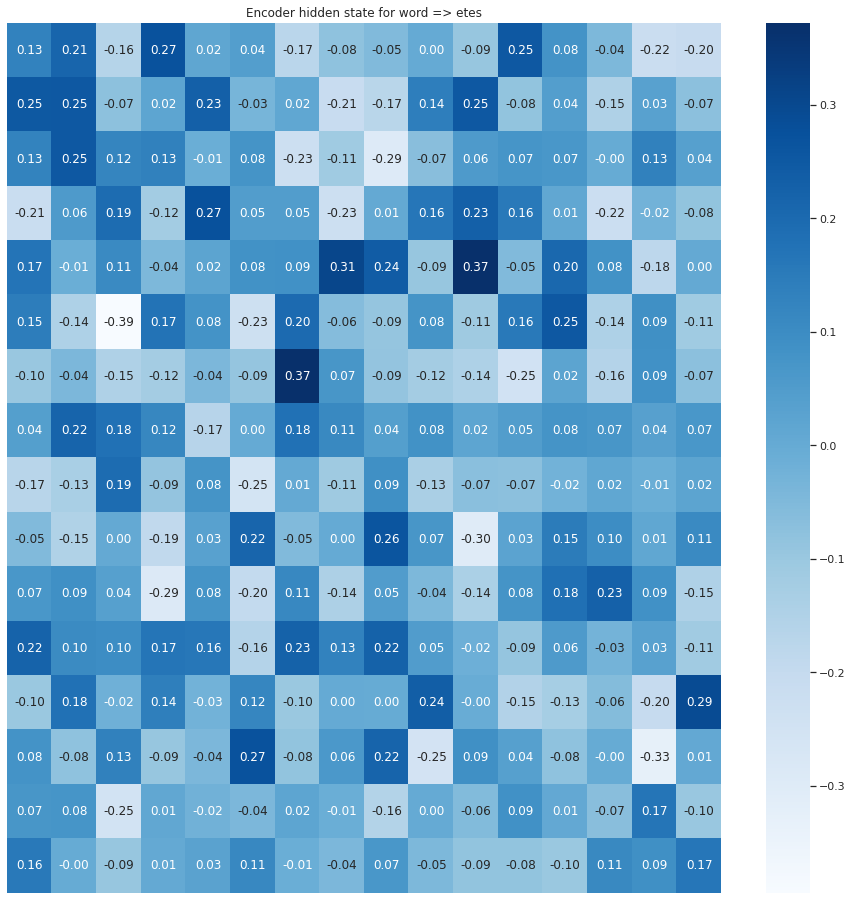




Step 2
Word => plus

Input Tensor => tensor(152, device='cuda:0')


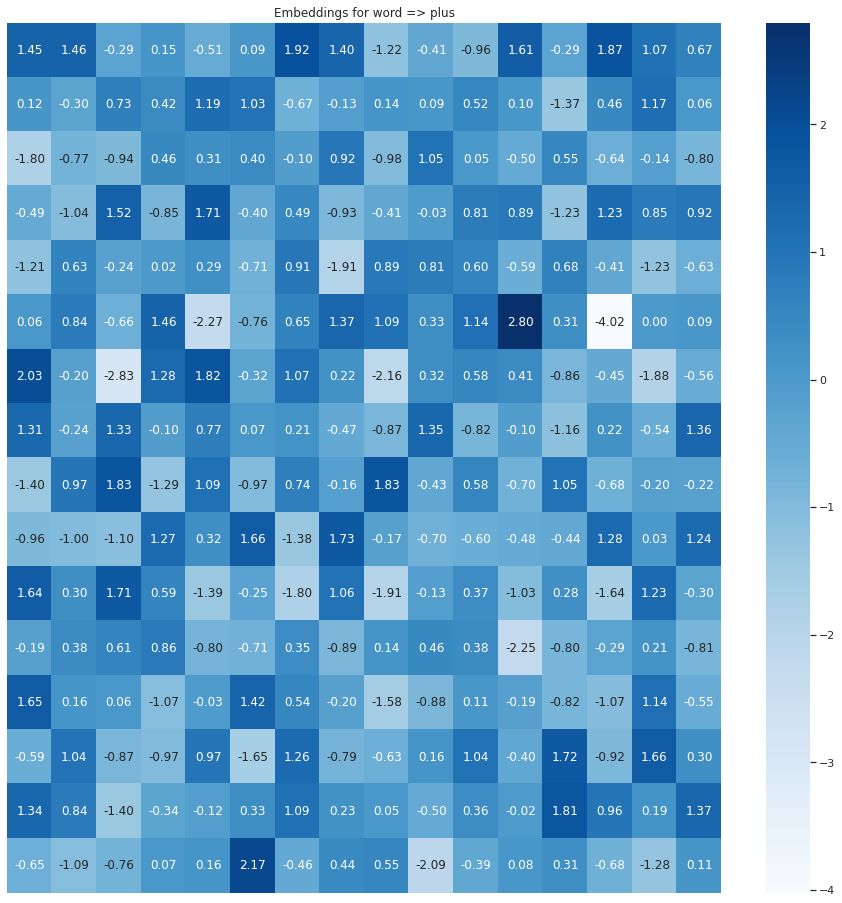

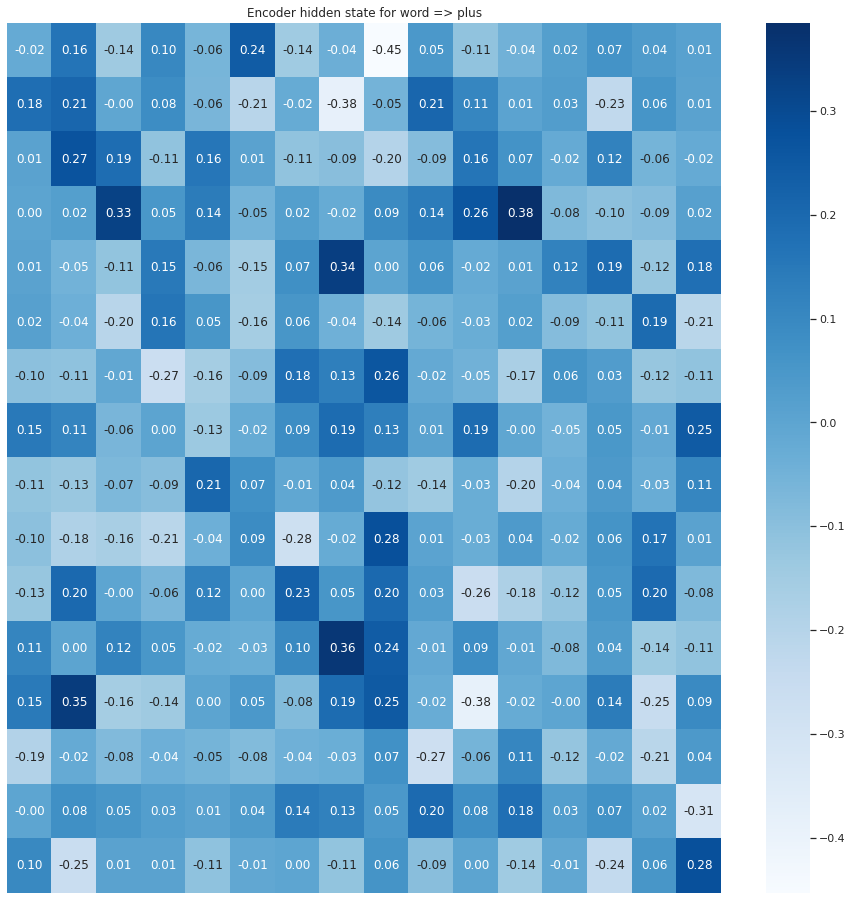




Step 3
Word => intelligent

Input Tensor => tensor(135, device='cuda:0')


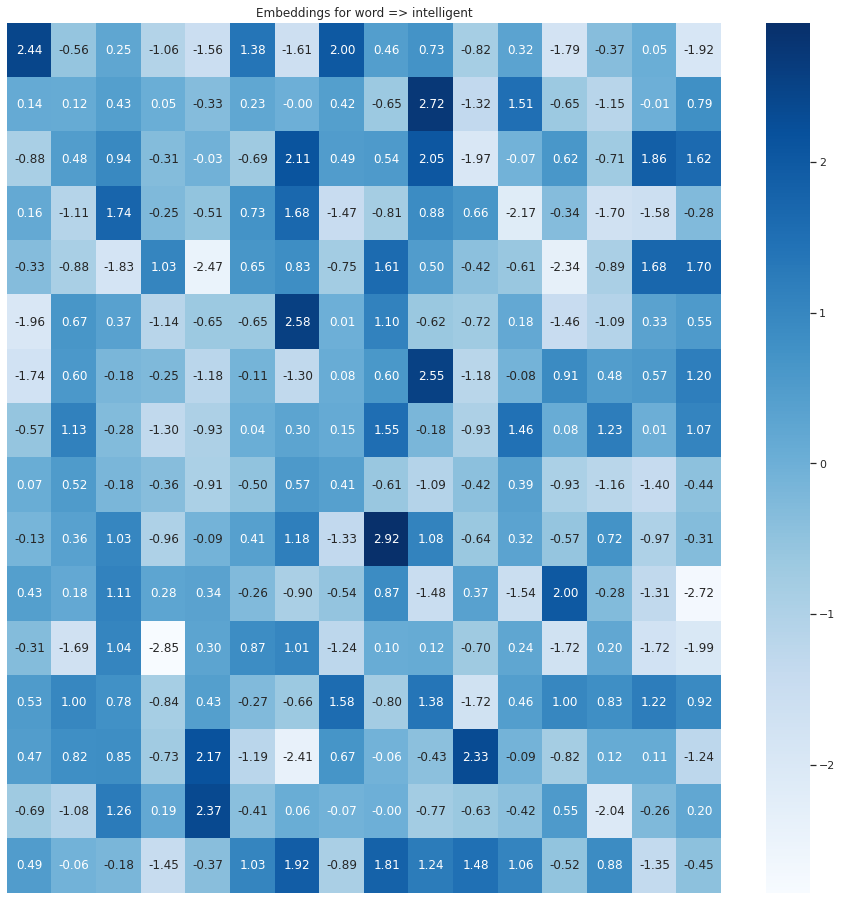

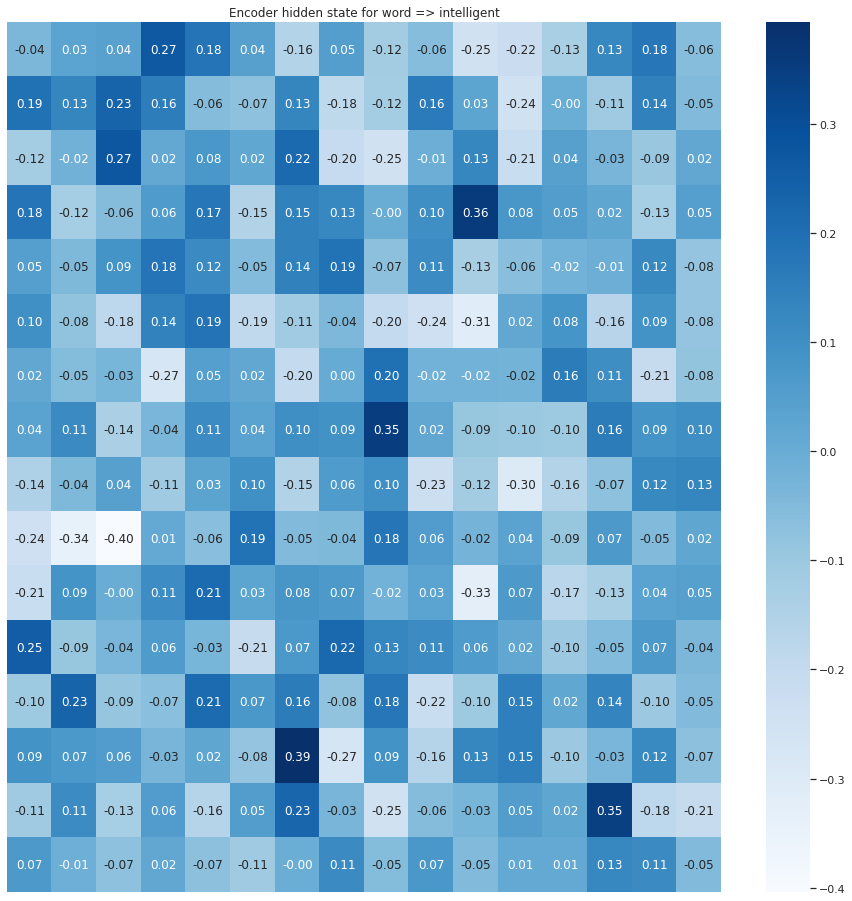




Step 4
Word => que

Input Tensor => tensor(902, device='cuda:0')


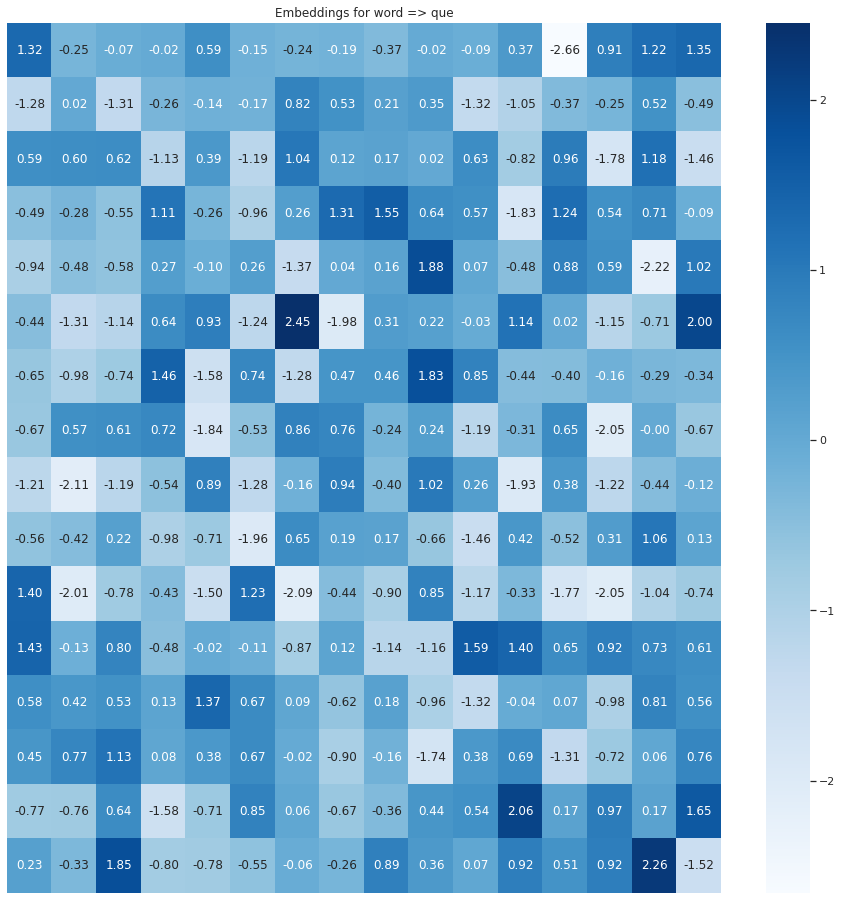

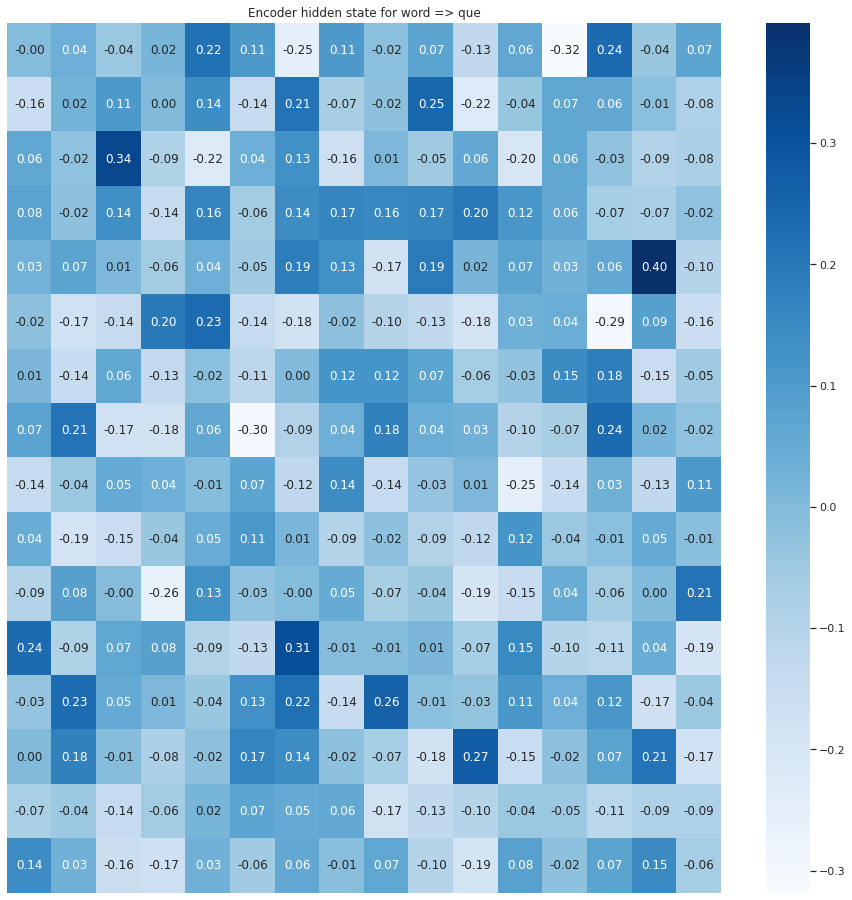




Step 5
Word => moi

Input Tensor => tensor(42, device='cuda:0')


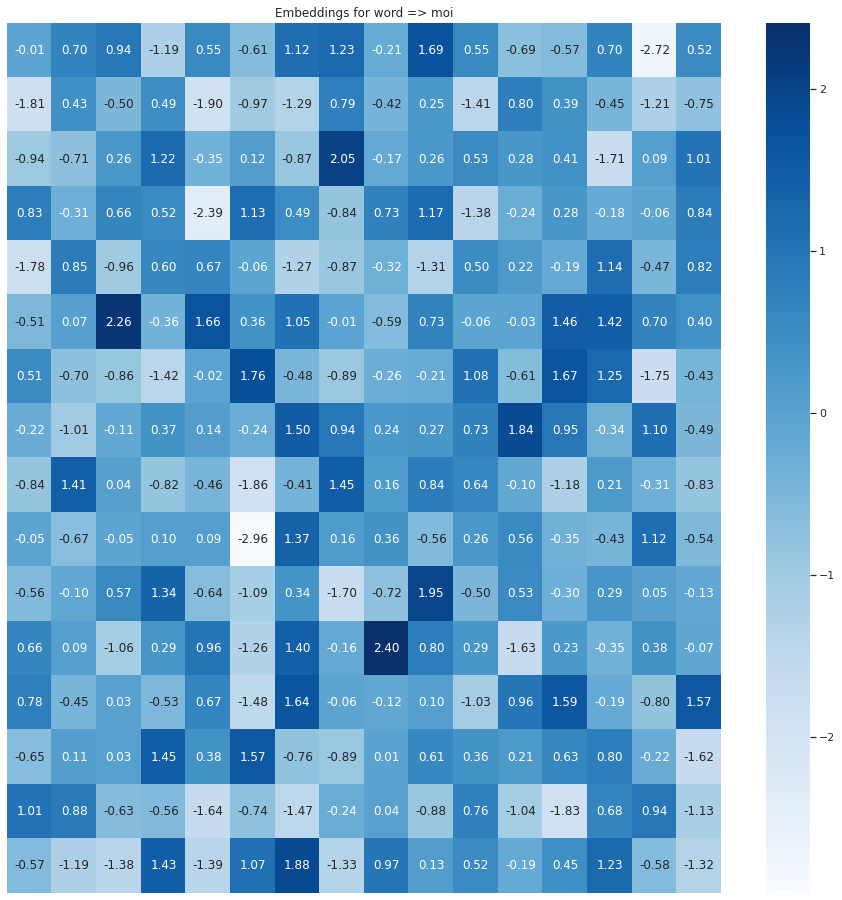

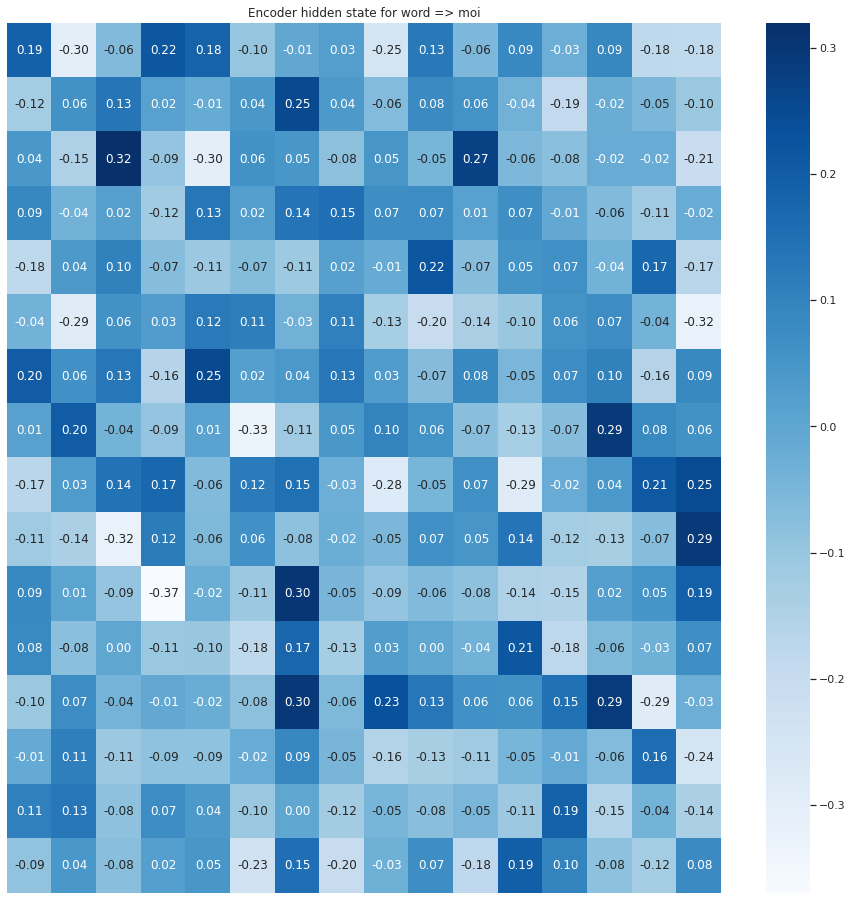




Step 6
Word => .

Input Tensor => tensor(5, device='cuda:0')


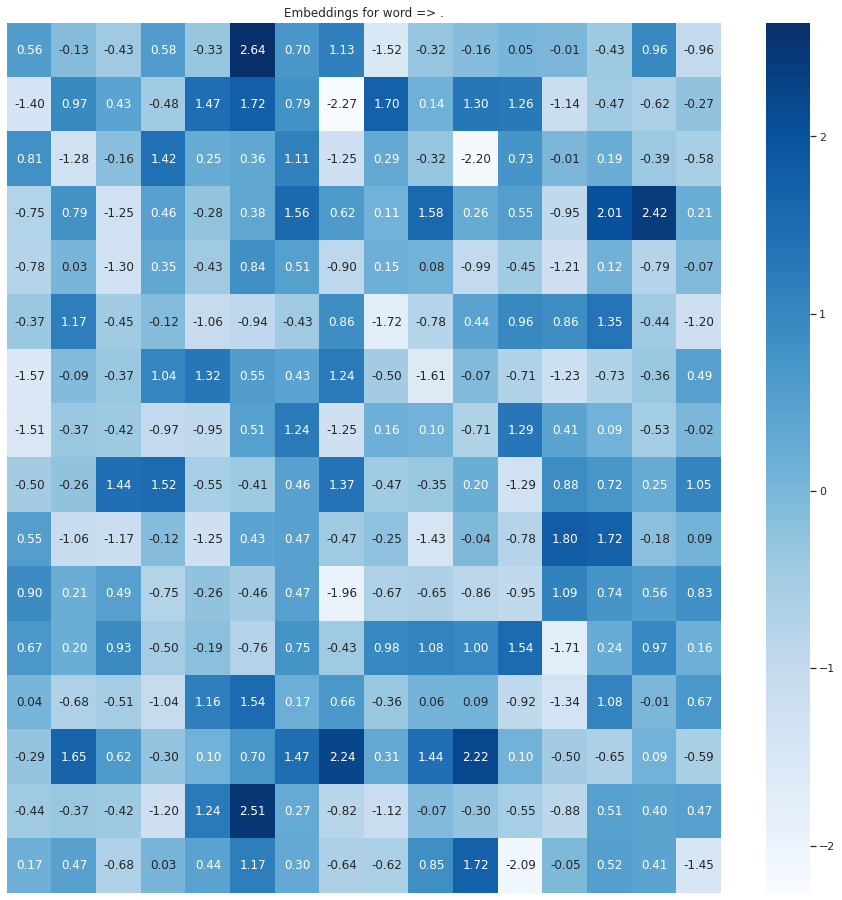

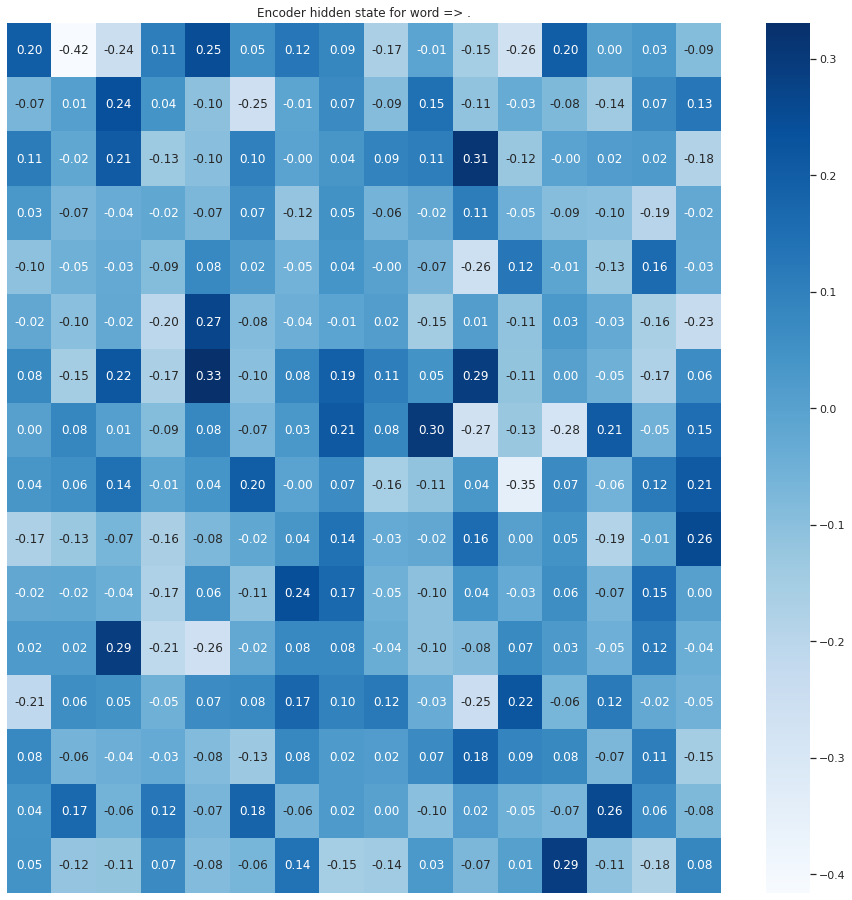




Step 7
Word => <EOS>

Input Tensor => tensor(1, device='cuda:0')


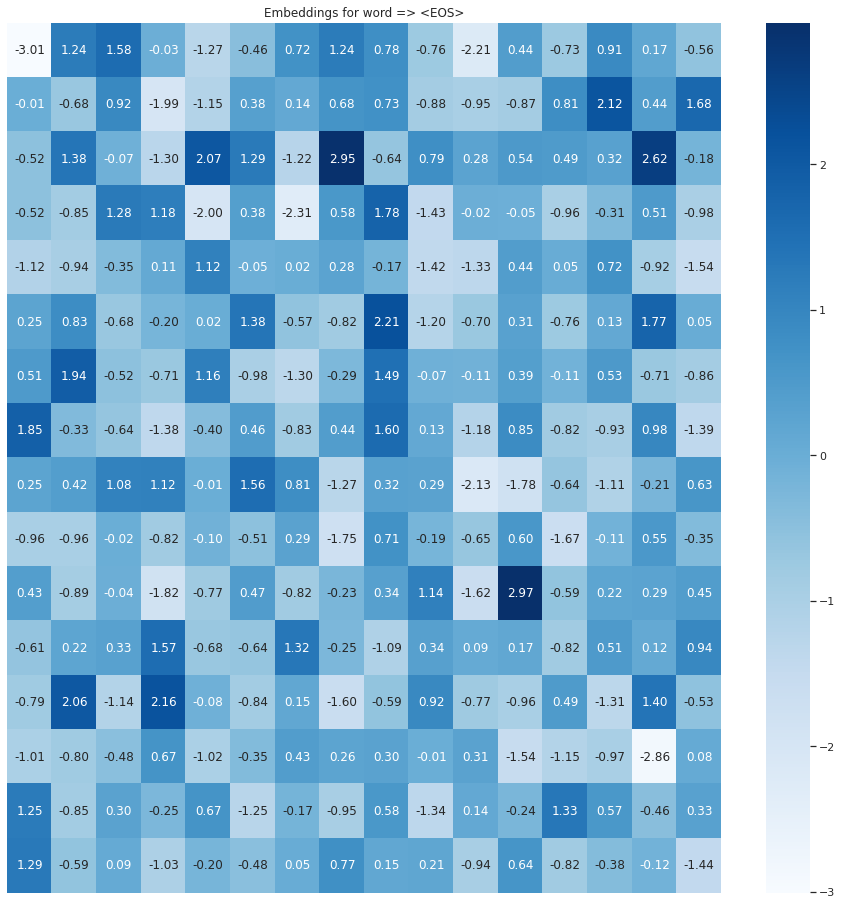

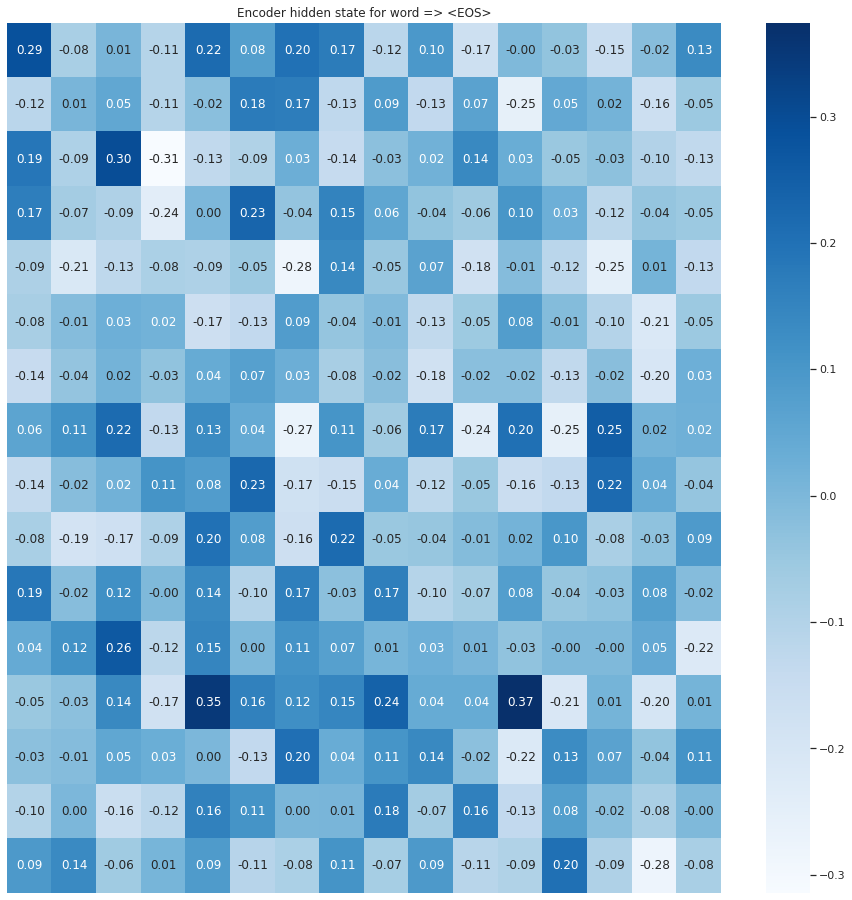

In [ ]:
input_sentence = sample[0]
target_sentence = sample[1]
print("Input Sentence:",sample[0])
print("Target Sentence:",sample[1])

input_indices = [input_lang.word2index[word] for word in input_sentence.split(' ')]
target_indices = [output_lang.word2index[word] for word in target_sentence.split(' ')]
print("Input indices:",input_indices)
print("Target indices:",input_indices)

input_indices.append(EOS_token)
target_indices.append(EOS_token)
print("After adding the <EOS> token")
print("Input indices:",input_indices)
print("Target indices:",input_indices)

input_tensor = torch.tensor(input_indices, dtype=torch.long, device= device)
output_tensor = torch.tensor(target_indices, dtype=torch.long, device= device)
print("Input tensor:",input_tensor)
print("Target tensor:",output_tensor)
print("\n\n")

print("Encoder part\n")
encoder_outputs = torch.zeros(MAX_LENGTH, 256, device=device)
(encoder_hidden,encoder_ct) = torch.zeros(1, 1, 256, device=device),torch.zeros(1, 1, 256, device=device)

for i in range(input_tensor.size()[0]):
  
  if (i<input_tensor.size()[0]-1):
    input_word = input_sentence.split(' ')[i] 
  else:
    input_word = "<EOS>"
  print('Step %d\nWord => %s\n'%(i,input_word))
  print("Input Tensor =>",input_tensor[i]) 
  embedded_input = embedding(input_tensor[i].view(-1, 1))
  embedded_input_cpu = embedded_input.cpu()
  plt.figure(figsize = (16,16))
  seaborn.heatmap(embedded_input_cpu.detach().numpy().reshape(-1, 16), fmt=".2f",annot=True, cmap="Blues").set(title=f"Embeddings for word => {input_word}")
  plt.xticks([])
  plt.yticks([])
  plt.show()
  output, (encoder_hidden,encoder_ct) = lstm(embedded_input, (encoder_hidden,encoder_ct))
  output_cpu = output[0,0].cpu()
  plt.figure(figsize = (16,16))
  seaborn.heatmap(output_cpu.detach().numpy().reshape(-1, 16), fmt=".2f",annot=True, cmap="Blues").set(title=f"Encoder hidden state for word => {input_word}")
  plt.xticks([])
  plt.yticks([])
  plt.show()
  encoder_outputs[i] += output[0,0]
  print("\n\n")

We completed the Encoder part now, Now we can start building the Attention Decoder<br>
* First input to the decoder will be SOS_token, later inputs would be the words it predicted (unless we implement teacher forcing).
* Decoder/LSTM's hidden state will be initialized with the encoder's last hidden state.
* We will use LSTM's hidden state and last prediction to generate attention weight using a FC layer.
* This attention weight will be used to weigh the encoder_outputs using batch matric multiplication. This will give us a NEW view on how to look at encoder_states.
* this attention applied encoder_states will then be concatenated with the input, and then sent a linear layer and then sent to the LSTM.
* LSTM's output will be sent to a FC layer to predict one of the output_language words

In [ ]:
# first input
decoder_input = torch.tensor([[SOS_token]], device=device)
(decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
decoded_words = []

In [ ]:
output_size = output_lang.n_words

embedding = nn.Embedding(output_size, 256).to(device)

In [ ]:
embedded = embedding(decoder_input)
embedded.shape

torch.Size([1, 1, 256])

In [ ]:
attn_weight_layer = nn.Linear(256 * 2, 10).to(device) 

In [ ]:
embedded.shape, decoder_hidden.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [ ]:
torch.cat((embedded, decoder_hidden), 1).shape

torch.Size([1, 2, 256])

We need to concatenate the embeddings and the last decoder hidden state

In [ ]:
torch.cat((embedded[0], decoder_hidden[0]), 1).shape

torch.Size([1, 512])

Now we will calaculate the attentions. We will calculating the attentions by conacatinating the embeddings and last decoder hidden state and giving as input to the fully connected layer.


In [ ]:
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights

tensor([[-0.8181,  0.0128,  0.0196, -0.3952, -0.1043, -0.1855, -0.5074, -0.4552,
         -0.5731,  0.5895]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
import torch.nn.functional as F

attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_weights

tensor([[0.1775, 0.0980, 0.0467, 0.0644, 0.0758, 0.0825, 0.1399, 0.0750, 0.1260,
         0.1142]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
attn_weights.shape, encoder_outputs.shape

(torch.Size([1, 10]), torch.Size([10, 256]))

In [ ]:
attn_weights.unsqueeze(0).shape, encoder_outputs.unsqueeze(0).shape

(torch.Size([1, 1, 10]), torch.Size([1, 10, 256]))

In [ ]:
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
attn_applied.shape

torch.Size([1, 1, 256])

In [ ]:
input_to_lstm_layer = nn.Linear(256 * 2, 256).to(device)

embedded.shape, attn_applied.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [ ]:
torch.cat((embedded, attn_applied), 1).shape, torch.cat((embedded[0], attn_applied[0]), 1).shape

(torch.Size([1, 2, 256]), torch.Size([1, 512]))

In [ ]:
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm.shape

torch.Size([1, 256])

In [ ]:
lstm = nn.LSTM(256, 256).to(device)

In [ ]:
decoder_hidden.shape, input_to_lstm.shape

(torch.Size([1, 1, 256]), torch.Size([1, 256]))

In [ ]:
input_to_lstm.unsqueeze(0).shape

torch.Size([1, 1, 256])

In [ ]:
output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm.unsqueeze(0), (decoder_hidden,decoder_ct))
output.shape, decoder_hidden.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [ ]:
output_word_layer = nn.Linear(256, output_lang.n_words).to(device)

In [ ]:
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
output, output.shape

(tensor([[0.0004, 0.0003, 0.0004,  ..., 0.0003, 0.0004, 0.0004]],
        device='cuda:0', grad_fn=<SoftmaxBackward>), torch.Size([1, 2803]))

In [ ]:
output.data.topk(1)

torch.return_types.topk(values=tensor([[0.0004]], device='cuda:0'), indices=tensor([[1455]], device='cuda:0'))

In [ ]:
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()]

'thought'

In [ ]:
top_index.item()

1455

In [ ]:
decoder_input = torch.tensor([[SOS_token]], device=device)
(decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
output_size = output_lang.n_words
embedding = nn.Embedding(output_size, 256).to(device)
embedded = embedding(decoder_input)
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm_layer = nn.Linear(256 * 2, 256).to(device)
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
lstm = nn.LSTM(256, 256).to(device)
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm, (decoder_hidden,decoder_ct))
output_word_layer = nn.Linear(256, output_lang.n_words).to(device)
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()]

'years'

In [ ]:
embedding = nn.Embedding(output_size, 256).to(device)
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
input_to_lstm_layer = nn.Linear(256 * 2, 256).to(device)
lstm = nn.LSTM(256, 256).to(device)
output_word_layer = nn.Linear(256, output_lang.n_words).to(device)


decoder_input = torch.tensor([[SOS_token]], device=device)
(decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
output_size = output_lang.n_words
embedded = embedding(decoder_input)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm, (decoder_hidden,decoder_ct))
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()], attn_weights

('executive',
 tensor([[0.1086, 0.0871, 0.1220, 0.0418, 0.0948, 0.0674, 0.2053, 0.1597, 0.0698,
          0.0435]], device='cuda:0', grad_fn=<SoftmaxBackward>))

In [ ]:
decoder_input = torch.tensor([[top_index.item()]], device=device)
(decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
output_size = output_lang.n_words
embedded = embedding(decoder_input)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm, (decoder_hidden,decoder_ct))
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()], attn_weights

('understands',
 tensor([[0.1491, 0.0676, 0.0925, 0.0650, 0.1461, 0.0807, 0.0757, 0.0374, 0.1648,
          0.1212]], device='cuda:0', grad_fn=<SoftmaxBackward>))

In [ ]:
decoder_input = torch.tensor([[target_indices[2]]], device=device)
(decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
output_size = output_lang.n_words
embedded = embedding(decoder_input)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm, (decoder_hidden,decoder_ct))
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()], attn_weights

('opposed',
 tensor([[0.1274, 0.1475, 0.0774, 0.1785, 0.1313, 0.0636, 0.0959, 0.0482, 0.0683,
          0.0619]], device='cuda:0', grad_fn=<SoftmaxBackward>))

In [ ]:
target_indices

[129, 78, 1319, 1166, 343, 4, 1]

Attention Decoder part With full Teacher forcing


Step 0
Expected output(word) => you 
Expected output(Index) => 129 
Predicted output(word) => opposed 
Predicted output(Index) => 2669 


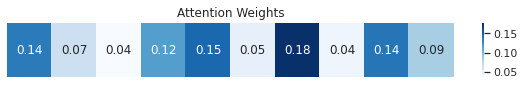


Step 1
Expected output(word) => re 
Expected output(Index) => 78 
Predicted output(word) => opposed 
Predicted output(Index) => 2669 


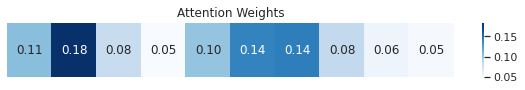


Step 2
Expected output(word) => smarter 
Expected output(Index) => 1319 
Predicted output(word) => opposed 
Predicted output(Index) => 2669 


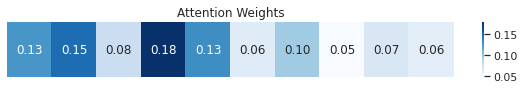


Step 3
Expected output(word) => than 
Expected output(Index) => 1166 
Predicted output(word) => options 
Predicted output(Index) => 1343 


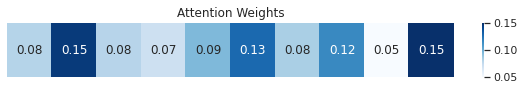


Step 4
Expected output(word) => me 
Expected output(Index) => 343 
Predicted output(word) => articulate 
Predicted output(Index) => 964 


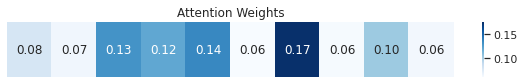


Step 5
Expected output(word) => . 
Expected output(Index) => 4 
Predicted output(word) => forgetting 
Predicted output(Index) => 2345 


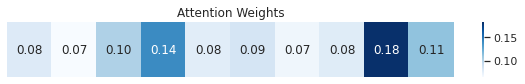

In [ ]:
print("Attention Decoder part With full Teacher forcing\n")
for i in range(6):
  print('\nStep %d'%(i))
  print('Expected output(word) => %s '% target_sentence.split(" ")[i])
  print('Expected output(Index) => %d '% target_indices[i])
  decoder_input = torch.tensor([[target_indices[i]]], device=device)
  (decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
  output_size = output_lang.n_words
  embedded = embedding(decoder_input)
  attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
  attn_weights = F.softmax(attn_weights, dim = 1)
  attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
  attn_weights_cpu = attn_weights.cpu()
  input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
  input_to_lstm = input_to_lstm.unsqueeze(0)
  output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm, (decoder_hidden,decoder_ct))
  output = F.relu(output)  
  output = F.softmax(output_word_layer(output[0]), dim = 1)
  top_value, top_index = output.data.topk(1)
  print('Predicted output(word) => %s '% output_lang.index2word[top_index.item()])
  print('Predicted output(Index) => %d '% top_index.item())  
  plt.figure(figsize = (10,1))
  seaborn.heatmap(attn_weights_cpu.detach().numpy().reshape(-1, 10), fmt=".2f",annot=True, cmap="Blues").set(title=f"Attention Weights")
  plt.xticks([])
  plt.yticks([])
  plt.show()
  #print(attn_weights)

In [ ]:
target_indices, target_sentence, input_sentence

([75, 40, 1388, 1389, 4, 1],
 'she is skipping rope .',
 'elle saute a la corde .')

In [ ]:
target_sentence.split(" ")[1]

'is'

In [ ]:
output_lang.index2word[top_index.item()]

'france'

In [ ]:
top_index.item()

622

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()